In [1]:
# Copyright © 2020, Johan Vonk
# SPDX-License-Identifier: MIT

In [176]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
import paho.mqtt.client as mqtt
from threading import Timer
import json
from config import username, password
import seaborn as sns
from itertools import count, filterfalse, cycle

In [3]:
a = {0}
b = [0]
for i in range(0,19):
    loc=next(filterfalse(a.__contains__, count(0)))
    d=dict()
    for c in range(max(b),max(b)+min(loc//4,10)+1):
        total=0
        for x in b:
            new=abs(loc+c-x)
            if new in a:
                total+=1
        d[c]=total
    shift=min(d, key=d.get)
    loc+=shift
    for x in b:
        new=abs(loc-x)
        a.add(new)
    b.append(loc)
positions={f"esp32-{i+1}":b[i]/50 for i in range(len(b))}

In [4]:
devices=pd.DataFrame(columns=("address", "firmware_version", "firmware_date","wifi_SSID","wifi_RSSI"))
df=pd.DataFrame(columns=("TIMESTAMP","SCANNER","ADVERTISER","TX POWER","RSSI","DISTANCE"))
class RepeatTimer(Timer):
    def run(self):
        while not self.finished.wait(self.interval):
            self.function(*self.args, **self.kwargs)

def switch_devices(client, devices):
    # print('switch_devices')
    client.publish("blescan/ctrl", payload="who")
    client.publish("blescan/ctrl", payload="int 150")
    for device,payload in zip(devices.index.values,np.random.choice(a=['scan', 'adv'],p=[0.7,0.3],size=len(devices))):
        client.publish("blescan/ctrl/"+device, payload=payload)

def on_connect(client, userdata, flags, rc):
    # print('on_connect')
    client.subscribe("blescan/data/#")
    client.publish("blescan/ctrl", payload="who")
    client.publish("blescan/ctrl", payload="int 150")

def on_message(client, userdata, msg):
    source = msg.topic.rsplit('/', 1)[-1]
    data = json.loads(msg.payload.decode('ASCII').replace('""','"'))
    # print("on_message",source,data,sep="\t")
    if "wifi" in data:
        devices.loc[data["name"]]=[data["address"],data["firmware"]["version"],pd.to_datetime(data["firmware"]["date"], format="%b %d %Y %H:%M:%S"),data["wifi"]["SSID"],data["wifi"]["RSSI"]]
    elif "RSSI" in data and data["name"] in positions and source in positions:
        sc_pos=positions[source]
        advertiser=data["name"]
        ad_pos=positions[advertiser]
        d=abs(sc_pos-ad_pos)
        df.loc[len(df)]=[pd.to_datetime("now"),source,advertiser,data["txPwr"],data["RSSI"],d]

client=mqtt.Client("reader")
client.on_connect = on_connect
client.on_message = on_message
client.connect('mqtt.vonk', 1883)
client.username_pw_set(username=username,password=password)
timer = RepeatTimer(60, switch_devices, args=(client,devices))
try:
    client.loop_start()
    timer.start()
except KeyboardInterrupt:
    client.loop_stop()
    timer.cancel()

In [260]:
d=df.copy()

In [271]:
N=3.09
rssi_1m=(np.log10(d['DISTANCE'])*N*10+d['RSSI']).mean()
temp=d.query('DISTANCE!=1')
d['LOG_PREDICTION']=(10**((rssi_1m-d['RSSI'])/10/N)).astype(float)
d['TX POWER']=pd.to_numeric(d['TX POWER'])
d['RSSI']=pd.to_numeric(d['RSSI'])

Received 6.1107 messages per second.
Estimated RSSI at 1 meter is -62.235.
N is 3.09.
Mean absolute percentage error is 39.720% for logarithmic model.


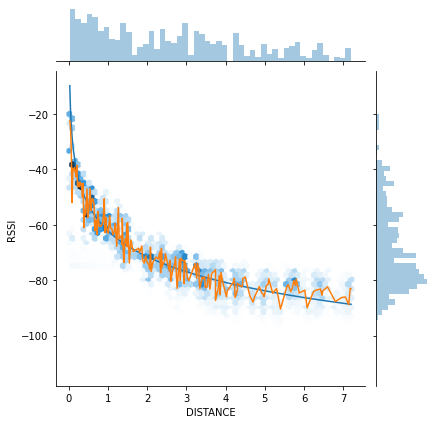

In [272]:
print('Received {0:.5} messages per second.'.format(len(d)/(d.iloc[-1]["TIMESTAMP"]-d.iloc[0]["TIMESTAMP"]).total_seconds()))
print('Estimated RSSI at 1 meter is {0:.5}.'.format(rssi_1m))
print('N is {0:.5}.'.format(N))
print('Mean absolute percentage error is {0:.3%} for logarithmic model.'.format((np.abs(d['LOG_PREDICTION']-d['DISTANCE'])/d['DISTANCE']).mean()))
g=sns.jointplot(x="DISTANCE", y="RSSI", data=d, kind="hex", joint_kws=dict(gridsize=50))
x = np.array(sorted(d['DISTANCE'].unique()))
g.ax_joint.plot(x,rssi_1m-10*N*np.log10(x))
g.ax_joint.plot(x,d.groupby('DISTANCE')['RSSI'].mean())
plt.show()

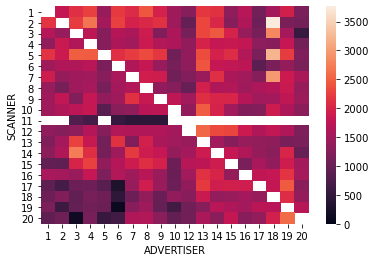

In [273]:
sns.heatmap(d.groupby([pd.to_numeric(d['SCANNER'].str.replace("esp32-","")),
                       pd.to_numeric(d['ADVERTISER'].str.replace("esp32-",""))])
             .count()['RSSI']
             .sort_index()
             .unstack(),
            vmin=0)

In [274]:
d.to_csv(f"pact_{d.iloc[0]['TIMESTAMP']:%Y%m%dT%H%M%S}.csv")